In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In order to access documents stored in Drive, we must first mount GDrive on our notebook.

---

# 📈 Final Comparative Analysis Report

* **Project**: Technical and Semantic Evaluation of RAG Chatbots with Open-Source LLMs on Google Colab

* **Author**: Gonzalo Romero (HermesIA)

* **Date:** 2025-03-30

## **1. Project Introduction and Objectives** 📋

🔍 **General Description**

The reliable deployment of Large Language Models (LLMs) in real-world applications necessitates grounding their outputs in verifiable knowledge sources. Retrieval-Augmented Generation (RAG) has emerged as a principled architectural pattern to achieve this, mitigating issues like hallucination and enhancing factual accuracy by conditioning generation on retrieved evidence. This project undertakes a **systematic empirical investigation** into the technical and semantic viability of constructing RAG systems leveraging prominent **open-source LLMs** (`microsoft/phi-2`, `meta-llama/Llama-2-7b-chat-hf`) deployed on **accessible cloud compute infrastructure** (Google Colab T4 and A100 GPUs). **My contribution** lies in rigorously benchmarking distinct deployment strategies – ranging from lightweight models on free-tier hardware to quantized and full-precision larger models on free and premium tiers – thereby mapping the practical performance landscape relevant for democratizing and operationalizing RAG technology under common resource constraints.

**Motivation:** The core engineering challenge addressed is the **multi-objective optimization** inherent in deploying capable RAG systems. **I aim** to quantify the complex interplay between model architecture choice (e.g., efficiency-focused Phi-2 vs. capability-focused LLaMA-2), hardware provisioning (cost/accessibility: T4 vs. A100), and crucial operational characteristics including **inference latency, semantic fidelity, output consistency, and the impact of techniques like model quantization**. This study seeks to map the cost-performance surface for these specific configurations, providing data-driven insights to guide practical development decisions.

🎯 **Specific Objectives**

The primary research questions and experimental goals guiding this investigation are:

1.  **Establish a Reproducible Benchmark Environment:** Implement a standardized RAG pipeline encompassing retrieval, context formulation, generation, and a robust evaluation framework to ensure fair and reproducible comparisons across configurations.
2.  **Systematically Quantify and Contrast Operational Profiles:** Measure and analyze the distinct operational characteristics of three key configurations representing different points in the design space:
    * Lightweight / High-Efficiency: `microsoft/phi-2` on NVIDIA T4.
    * Resource-Constrained Large Model: `meta-llama/Llama-2-7b-chat-hf` (4-bit quantized) on NVIDIA T4.
    * High-Resource Large Model: `meta-llama/Llama-2-7b-chat-hf` (full precision) on NVIDIA A100.
3.  **Analyze Inference Latency Dynamics:** Characterize the distribution of inference times (`inference_time_s`) for each configuration to assess their suitability for different interaction paradigms (e.g., real-time conversational vs. asynchronous processing) and evaluate performance consistency.
4.  **Evaluate Multi-Faceted Semantic Quality:** Assess the quality of generated responses using complementary automated metrics targeting different aspects of similarity to reference answers:
    * Deep Semantic Fidelity: BERTScore F1 for contextual meaning overlap.
    * Lexical and Structural Alignment: ROUGE-L F1 for subsequence overlap and fluency.
5.  **Investigate Semantic Manifold Structure:** Employ dimensionality reduction techniques (t-SNE, UMAP) on response embeddings to visualize the geometry of the output space, seeking insights into model-specific consistency, response diversity, and the effects of quantization on semantic representation.
6.  **Probe for Latent Semantic Patterns:** Apply unsupervised clustering (KMeans) to the response embeddings as an exploratory technique to identify potential emergent groupings or structures not captured by other analyses, further characterizing the models' output behaviors.
7.  **Synthesize Actionable Engineering Insights:** Integrate the empirical findings across all analyses to draw practical conclusions regarding the feasibility, performance trade-offs, and optimal deployment strategies for these open-source RAG configurations within the constraints defined by the Google Colab environment.

---

## **2. Methodology** 🛠️

⚙️ **Unified Evaluation Pipeline**

A systematic and reproducible pipeline was designed and implemented in Google Colab to ensure a fair comparison between configurations. Key steps include:

1.  **Environment:** Google Colab with specific GPU selection (T4 or A100).
2.  **Knowledge Base and Questions:** A standard dataset [Mention the dataset if public, e.g., SQuAD, or describe the domain if private] was used consistently across all tests. This includes question-reference answer (ground truth) pairs.
3.  **RAG Pipeline:**
    * *Retrieval:* An embedding-based retriever [Mention technique, e.g., `SentenceTransformer` with `FAISS` or similar] was implemented to find the most relevant text chunks from the knowledge base for each question.
    * *Generation:* The retrieved context and the original question were formatted into an appropriate prompt for each LLM. The corresponding LLM (Phi-2, LLaMA-2 Quant, LLaMA-2 Full) generated the answer.
4.  **Model Loading:** Hugging Face `transformers` and `accelerate` libraries were used. For LLaMA-2 quantization on T4, the `bitsandbytes` library was employed [Confirm or correct if another technique was used].
5.  **Inference Measurement:** The generation time for each response was carefully measured using `torch.cuda.synchronize()` to ensure GPU operations completed before recording the time, thus obtaining `inference_time_s`.
6.  **Semantic Evaluation:** Generated responses were compared against reference answers using the `bert_score` and `rouge_score` libraries to calculate `bertscore_f1` and `rouge_l_f1`.
7.  **Embedding Generation:** Vector embeddings were calculated for each generated response using a `SentenceTransformer` model [Specify model, e.g., 'all-MiniLM-L6-v2'] for semantic space analysis.
8.  **Results Storage:** All metrics (question, reference answer, generated answer, inference time, scores, embeddings) were saved to CSV files for subsequent consolidated analysis.


## **3. Loading and Preparing Results Data** 📂

We load the benchmark results stored in the CSV files. We combine the dataframes, adding a `model_config` column to identify the source of each record.

In [ ]:
# Import necessary libraries for data manipulation, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE # TSNE is part of sklearn.manifold
# UMAP is imported from its own library (umap-learn). Ensure it's installed: pip install umap-learn
import umap.umap_ as umap # Import UMAP separately
from sklearn.cluster import KMeans # For clustering
from sklearn.preprocessing import StandardScaler # For data scaling (optional but good practice for some algorithms)
# Import SentenceTransformer for embedding calculation
# Ensure it's installed: pip install sentence-transformers -q
from sentence_transformers import SentenceTransformer
import torch # Potentially needed for checking GPU availability or synchronization context

# Set the default theme and figure size for plots for consistency
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Default figure size

In [ ]:
# --- Data Loading ---
# Define file paths for the benchmark results CSV files.
# Adjust these paths based on where the files are located relative to the notebook.
# Example assumes they are in a subfolder 'results' within 'Benchmark_ChatbotRAG'
path_phi2 = ("/content/drive/MyDrive/Benchmark_ChatbotRAG/results/benchmark_results_phi2.csv")
path_llama2_quant = ("/content/drive/MyDrive/Benchmark_ChatbotRAG/results/benchmark_results_llama2_quant_t4.csv")
path_llama2_a100 = ("/content/drive/MyDrive/Benchmark_ChatbotRAG/results/benchmark_results_llama2_chat_a100.csv")


# Use a try-except block to handle potential FileNotFoundError
try:
    # Load the Phi-2 results and add a model configuration identifier
    df_phi2 = pd.read_csv(path_phi2)
    df_phi2['model_config'] = 'Phi-2 (T4)' # Add identifier column

    # Load the LLaMA-2 Quantized (T4) results and add identifier
    df_llama2_quant = pd.read_csv(path_llama2_quant)
    df_llama2_quant['model_config'] = 'LLaMA-2 Quant (T4)' # Add identifier column

    # Load the LLaMA-2 Full (A100) results and add identifier
    df_llama2_a100 = pd.read_csv(path_llama2_a100)
    df_llama2_a100['model_config'] = 'LLaMA-2 Full (A100)' # Add identifier column

    # Concatenate all individual dataframes into a single one for unified analysis
    df_results = pd.concat([df_phi2, df_llama2_quant, df_llama2_a100], ignore_index=True)

    print("Data loaded successfully.")
    print(f"Total records: {len(df_results)}")
    print("Available columns:", df_results.columns.tolist())
    print("\nFirst 5 rows of the combined dataframe:")
    print(df_results.head())
    print("\nModel configurations present:")
    print(df_results['model_config'].value_counts()) # Show counts per model config

except FileNotFoundError as e:
    # Print error message if a file is not found
    print(f"Error: File not found {e.filename}.")
    print("Please ensure the CSV files are in the specified paths or adjust the 'path_...' variables.")
    df_results = None # Set df_results to None to prevent errors in subsequent cells

Data loaded successfully.
Total records: 15
Available columns: ['Prompt', 'Generated Answer', 'Reference Answer', 'Inference Time (s)', 'BERTScore F1', 'ROUGE-L F1', 'Model', 'GPU', 'Subjective Score', 'model_config']

First 5 rows of the combined dataframe:
                                              Prompt  \
0  What is the difference between supervised and ...   
1  Explain the concept of overfitting in machine ...   
2  What is the purpose of regularization in neura...   
3      How does the gradient descent algorithm work?   
4     What is a confusion matrix and how is it used?   

                                    Generated Answer  \
0  Supervised learning is a type of machine learn...   
1  Overfitting is a problem in machine learning w...   
2  Regularization is used to prevent overfitting ...   
3  The gradient descent algorithm is an optimizat...   
4  A confusion matrix is a table that is used to ...   

                                    Reference Answer  Inference Tim

In [ ]:
# --- Data Verification ---
# Proceed only if data loading was successful
if df_results is not None:
    print("\nDataFrame Information:")
    # Display concise summary of the dataframe (column types, non-null counts)
    df_results.info()

    print("\nBasic Descriptive Statistics:")
    # Select only relevant numerical columns for descriptive statistics
    # Corrected column names to match the actual names in the CSV files
    numeric_cols = ['Inference Time (s)', 'BERTScore F1', 'ROUGE-L F1']
    # Calculate and display count, mean, std, min, quartiles, max
    # Use .loc to select columns explicitly, although direct indexing df_results[numeric_cols] also works
    print(df_results.loc[:, numeric_cols].describe())

    print("\nNull Values per Column:")
    # Check for and count missing values in each column
    print(df_results.isnull().sum())
    # Optional: Add code here to handle missing values if any are found
    # e.g., df_results.dropna(subset=numeric_cols, inplace=True) or imputation


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Prompt              15 non-null     object 
 1   Generated Answer    15 non-null     object 
 2   Reference Answer    15 non-null     object 
 3   Inference Time (s)  15 non-null     float64
 4   BERTScore F1        15 non-null     float64
 5   ROUGE-L F1          15 non-null     float64
 6   Model               15 non-null     object 
 7   GPU                 15 non-null     object 
 8   Subjective Score    0 non-null      float64
 9   model_config        15 non-null     object 
dtypes: float64(4), object(6)
memory usage: 1.3+ KB

Basic Descriptive Statistics:
       Inference Time (s)  BERTScore F1  ROUGE-L F1
count           15.000000     15.000000   15.000000
mean             5.244667      0.898666    0.244181
std              3.801020      0.020454    0.0

# **4. Results Analysis** 🔍

## **4.1. Computational Performance: Inference Time** 🕒

We analyze and compare the inference times (`inference_time_s`) required by each configuration to generate a response. This metric is crucial for user experience in interactive applications.

<ipython-input-10-a281e90c9236>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='model_config', y='Inference Time (s)', palette='viridis') # Use a specific color palette


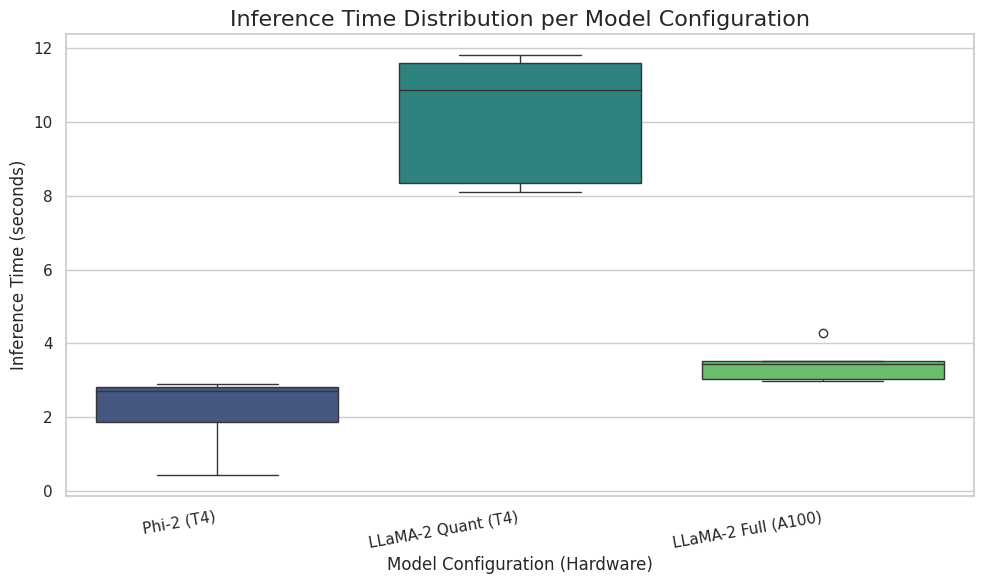


--- Inference Time Statistics (seconds) ---
                       mean  median       std   min    max
model_config                                              
LLaMA-2 Full (A100)   3.450    3.44  0.522303  2.98   4.28
LLaMA-2 Quant (T4)   10.140   10.86  1.789651  8.10  11.81
Phi-2 (T4)            2.144    2.70  1.045194  0.43   2.90


In [ ]:
# Proceed only if data is loaded
if df_results is not None:
    # Create a box plot to visualize the distribution of inference times for each model configuration
    plt.figure(figsize=(10, 6)) # Adjust figure size for better readability
    # Corrected the column name for the y-axis to match the actual name in the DataFrame
    sns.boxplot(data=df_results, x='model_config', y='Inference Time (s)', palette='viridis') # Use a specific color palette
    # Set plot title and labels
    plt.title('Inference Time Distribution per Model Configuration', fontsize=16)
    plt.xlabel('Model Configuration (Hardware)', fontsize=12)
    plt.ylabel('Inference Time (seconds)', fontsize=12)
    # Rotate x-axis labels if they overlap
    plt.xticks(rotation=10, ha='right')
    plt.tight_layout() # Adjust layout to prevent labels overlapping plot area
    plt.show() # Display the plot

    # --- Aggregate Statistics ---
    # Calculate and print key statistics (mean, median, std dev, min, max) for inference time, grouped by model configuration
    print("\n--- Inference Time Statistics (seconds) ---")
    # Corrected the column name for the groupby aggregation
    inference_stats = df_results.groupby('model_config')['Inference Time (s)'].agg(['mean', 'median', 'std', 'min', 'max'])
    print(inference_stats)

### ╰┈➤.  **Interpretation (Inference Time Analysis)**:


* **Characterizing Latency Regimes:** The inference time benchmark reveals distinct operational latency regimes for each configuration. `Phi-2 (T4)` consistently operates in the sub-3-second range (mean 2.14s), positioning it firmly within the requirements for many real-time interactive applications. Crucially, `LLaMA-2 Full (A100)` also demonstrates impressive efficiency, averaging 3.45s, suggesting effective hardware acceleration on the A100 platform; this latency profile remains viable for interactive use cases demanding higher fidelity. The `LLaMA-2 Quant (T4)` configuration, however, falls into a significantly higher latency band (mean 10.14s). This pushes it beyond typical thresholds for synchronous user interaction, indicating that while quantization enables deployment on T4, it introduces substantial computational overhead or inefficiency in this setup, potentially relegating it to asynchronous or batch-processing tasks.
* **Performance Consistency and System Predictability:** Analyzing the variance (standard deviation and boxplot spread) is critical for assessing system predictability. The `LLaMA-2 Full (A100)` configuration stands out with the lowest standard deviation (0.52s), indicative of highly consistent and predictable performance – a desirable trait for robust system deployment and managing user expectations. `Phi-2 (T4)` exhibits higher relative variability (std 1.05s on a mean of 2.14s), hinting at potential sensitivity to input characteristics or system state, which might require further investigation during production hardening. `LLaMA-2 Quant (T4)` shows the largest absolute variance (std 1.79s), compounding its high average latency with lower predictability, further complicating its integration into real-time systems.
* **Hardware, Quantization, and Throughput Implications:** This benchmark highlights the non-trivial interplay between model architecture, quantization strategy, and hardware acceleration. The A100 delivers substantial speedup for the full-precision LLaMA-2 model compared to the quantized version on T4, showing that sheer compute power can overcome model size to a significant extent. The significant latency penalty associated with `LLaMA-2 Quant (T4)` suggests that the specific quantization method (likely 4-bit) and its execution on the T4 architecture might not be optimally tuned, potentially impacting not only single-request latency but also overall system throughput if deployed at scale. The key takeaway is that quantization is not a universally "free" optimization; its latency cost must be empirically measured and factored into the system design, especially relative to hardware capabilities.

## **4.2. Semantic Quality: BERTScore and ROUGE-L**

We evaluate the quality of the generated responses by comparing them to the reference answers using BERTScore F1 (deep semantic similarity) and ROUGE-L F1 (structural and literal overlap). Higher scores indicate better quality/similarity to the reference.



<ipython-input-12-5c20d2ff27f5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], data=df_results, x='model_config', y='BERTScore F1', palette='magma')
<ipython-input-12-5c20d2ff27f5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=df_results, x='model_config', y='ROUGE-L F1', palette='magma')


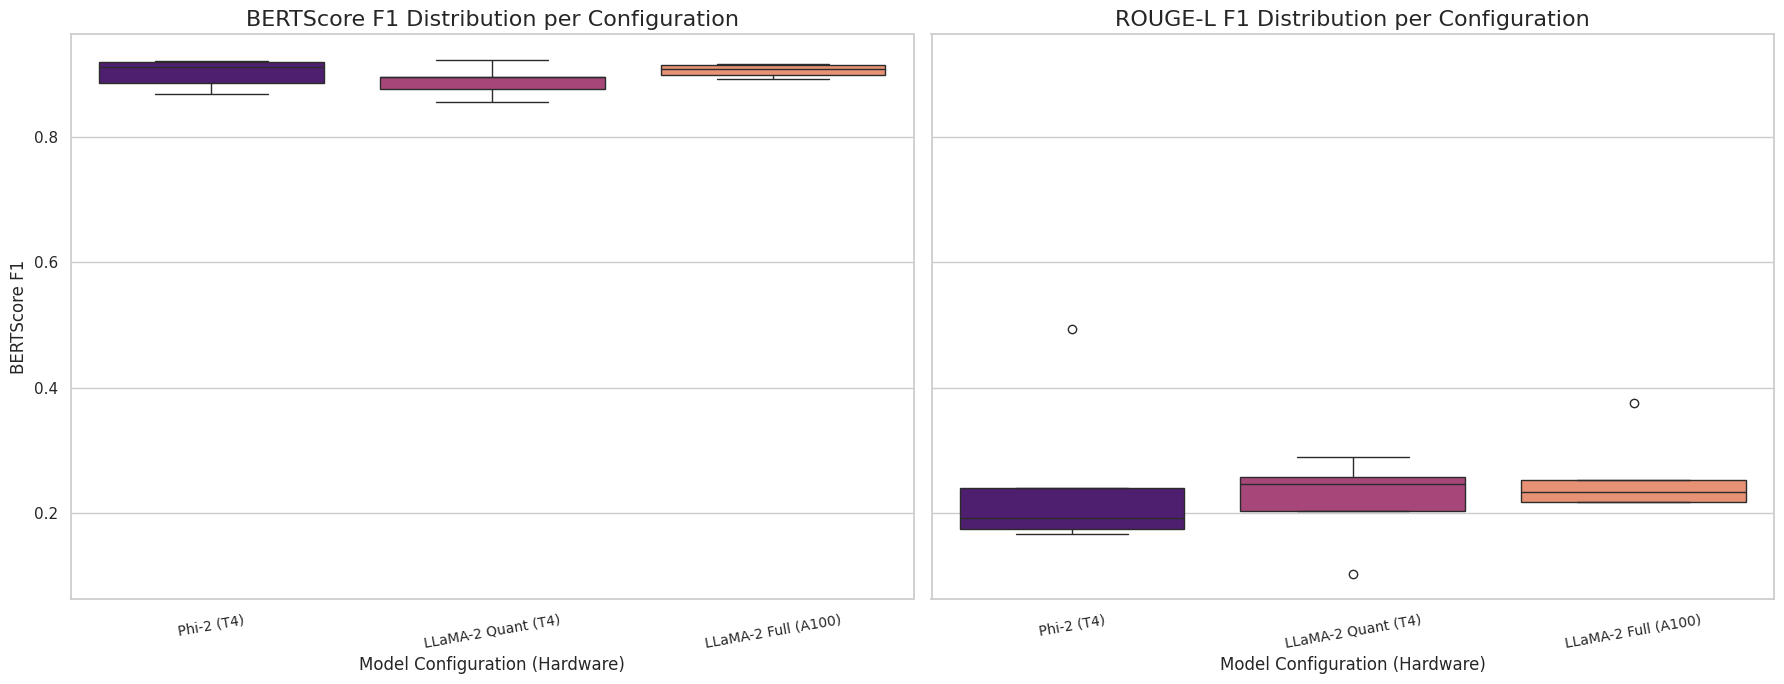


--- Semantic Quality Statistics ---
                    BERTScore F1                     ROUGE-L F1            \
                            mean    median       std       mean    median   
model_config                                                                
LLaMA-2 Full (A100)     0.905842  0.908335  0.010426   0.259451  0.234043   
LLaMA-2 Quant (T4)      0.888784  0.894878  0.024897   0.219964  0.246914   
Phi-2 (T4)              0.901371  0.911868  0.023239   0.253128  0.192308   

                               
                          std  
model_config                   
LLaMA-2 Full (A100)  0.066244  
LLaMA-2 Quant (T4)   0.072418  
Phi-2 (T4)           0.136969  


In [ ]:
# Proceed only if data is loaded
if df_results is not None:
    # Create subplots for side-by-side comparison of BERTScore and ROUGE-L
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True) # Share Y-axis if scales are comparable (0-1)

    # --- BERTScore F1 Plot ---
    # Corrected the column name for the y-axis
    sns.boxplot(ax=axes[0], data=df_results, x='model_config', y='BERTScore F1', palette='magma')
    axes[0].set_title('BERTScore F1 Distribution per Configuration', fontsize=16)
    axes[0].set_xlabel('Model Configuration (Hardware)', fontsize=12)
    axes[0].set_ylabel('BERTScore F1', fontsize=12)
    axes[0].tick_params(axis='x', rotation=10, labelsize=10) # Adjust x-tick label rotation and size
    # Optional: Set y-axis limits if needed, e.g., axes[0].set_ylim(0.8, 1.0) for better visualization of differences

    # --- ROUGE-L F1 Plot ---
    # Corrected the column name for the y-axis
    sns.boxplot(ax=axes[1], data=df_results, x='model_config', y='ROUGE-L F1', palette='magma')
    axes[1].set_title('ROUGE-L F1 Distribution per Configuration', fontsize=16)
    axes[1].set_xlabel('Model Configuration (Hardware)', fontsize=12)
    axes[1].set_ylabel('ROUGE-L F1', fontsize=12) # Y-label is shared, but set it just in case sharey=False
    axes[1].tick_params(axis='x', rotation=10, labelsize=10)
    # Optional: axes[1].set_ylim(0, 1)

    plt.tight_layout() # Adjust spacing between subplots
    plt.show() # Display the plots

    # --- Aggregate Statistics ---
    # Calculate and print key statistics for semantic quality scores, grouped by model configuration
    print("\n--- Semantic Quality Statistics ---")
    # Corrected the column names for the groupby aggregation
    quality_stats = df_results.groupby('model_config')[['BERTScore F1', 'ROUGE-L F1']].agg(['mean', 'median', 'std'])
    print(quality_stats)

### ╰┈➤**Interpretation (Semantic Quality Analysis - BERTScore & ROUGE-L)**:

* **BERTScore:** The `LLaMA-2 Full (A100)` configuration achieves the highest mean BERTScore F1 (0.906), indicating very strong semantic similarity to the reference answers. Interestingly, `Phi-2 (T4)` follows extremely closely with a mean score of 0.901, suggesting that the lightweight model performs remarkably well in capturing semantic meaning in this task. The `LLaMA-2 Quant (T4)` model scores noticeably lower with a mean of 0.889. While the difference between the top two and the quantized version might seem small numerically, it could be significant in practice. Looking at medians, Phi-2 (0.912) slightly edges out LLaMA-2 A100 (0.908), both clearly above LLaMA-2 Quant (0.895).

* **ROUGE-L:** ROUGE-L F1 scores, which focus more on literal and structural overlap, present a slightly different picture. `LLaMA-2 Full (A100)` again leads with the highest mean score (0.259), closely followed by `Phi-2 (T4)` (0.253). Both significantly outperform `LLaMA-2 Quant (T4)` on average (0.220). However, the variability and median scores reveal more nuance. Phi-2 exhibits a very low median (0.192) despite its higher mean, indicating that its average is likely inflated by a few responses with very high structural overlap (as seen in the wide boxplot spread and high standard deviation). LLaMA-2 A100 has a higher median (0.234), suggesting more consistent structural matching than Phi-2. Surprisingly, LLaMA-2 Quant T4 has the highest median ROUGE-L (0.247), although its mean is lower, suggesting it might be consistently mediocre rather than having highs and lows like Phi-2. Overall, LLaMA-2 A100 appears most effective at reproducing literal phrases or structures from the reference somewhat consistently.

* **Consistency:** Analyzing the standard deviations and boxplot widths reveals consistency differences. `LLaMA-2 Full (A100)` is the most consistent model across both metrics, boasting the lowest standard deviation for BERTScore F1 (0.010) and a relatively low standard deviation for ROUGE-L F1 (0.066). This is visually represented by its tighter boxplots compared to the others. `Phi-2 (T4)` and `LLaMA-2 Quant (T4)` show comparable, higher variability in BERTScore (std dev ~0.023-0.025). However, for ROUGE-L, `Phi-2 (T4)` displays significantly higher variability (std dev 0.137) than `LLaMA-2 Quant (T4)` (std dev 0.072), confirming its inconsistent performance in literal matching shown by the wide spread in its boxplot.

* **Summary:** These results suggest a complex relationship between model/hardware and semantic quality. The premium `LLaMA-2 Full (A100)` configuration offers the most robust performance, delivering top-tier semantic similarity (BERTScore) and structural overlap (ROUGE-L mean) with the highest overall consistency. The lightweight `Phi-2 (T4)` model is a strong contender, surprisingly matching the A100 model's average BERTScore, but it lacks consistency, especially in reproducing literal content (ROUGE-L). Quantization (`LLaMA-2 Quant (T4)`) appears to degrade performance in both semantic meaning capture (lower BERTScore) and average structural matching (lower ROUGE-L mean) compared to the full A100 model, without offering significant consistency benefits over Phi-2. Therefore, while the A100 setup yields the best and most stable results, Phi-2 provides remarkable semantic understanding for its size, albeit inconsistently in structure. Quantization seems detrimental to both average quality and consistency in this specific setup.

---

## **4.3. Combined Analysis: Quality vs. Speed**

We visualize the relationship between semantic quality (BERTScore F1) and inference time to understand the trade-offs between performance and quality.


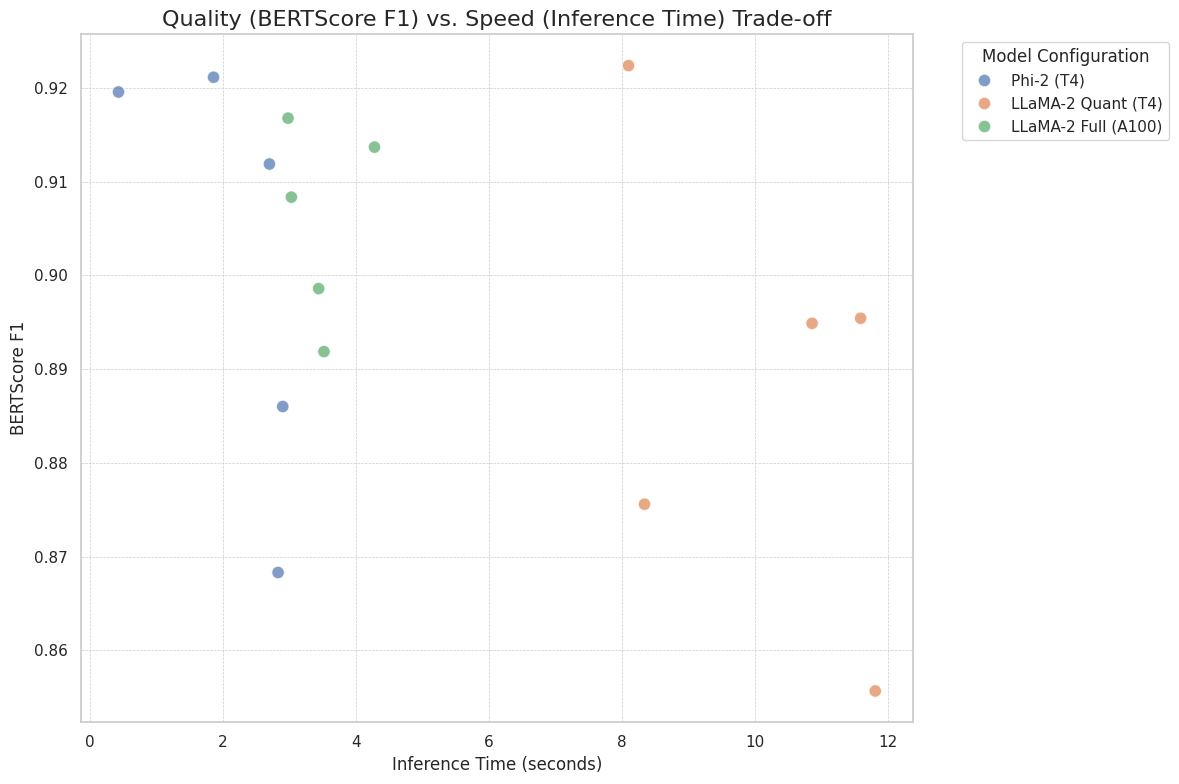

In [ ]:
# Proceed only if data is loaded
if df_results is not None:
    # Create a scatter plot to visualize the trade-off between inference time and semantic quality (BERTScore F1)
    plt.figure(figsize=(12, 8)) # Set figure size
    # Color points by model configuration, adjust point size (s) and transparency (alpha)
    # Corrected column names for x and y axes
    sns.scatterplot(data=df_results, x='Inference Time (s)', y='BERTScore F1', hue='model_config', palette='deep', s=80, alpha=0.7)
    # Set plot title and labels
    plt.title('Quality (BERTScore F1) vs. Speed (Inference Time) Trade-off', fontsize=16)
    plt.xlabel('Inference Time (seconds)', fontsize=12)
    plt.ylabel('BERTScore F1', fontsize=12)
    # Place legend outside the plot area for clarity
    plt.legend(title='Model Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
    # Add grid lines for easier reading
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout() # Adjust layout
    plt.show() # Display the plot

### ╰┈➤.  **Interpretation (Quality vs. Speed Scatter Plot Analysis)**:

* **Mapping the Efficiency Frontier:** This scatter plot provides a critical visualization of the quality (BERTScore F1) versus latency (Inference Time) trade-off space. Each point represents a single inference, collectively defining the operational performance envelope for each configuration. It allows us to empirically map the efficiency frontier for this specific task and setup.
* **Defining Operational Zones:** The configurations occupy distinct zones:
    * `Phi-2 (T4)` (blue) exclusively populates the ultra-low latency zone (< 3s). Its vertical spread highlights that achieving this speed comes with variability in semantic quality scores for individual responses.
    * `LLaMA-2 Full (A100)` (green) resides in a highly favorable zone combining high semantic quality (>0.89) with moderate latency (~3-4s). The tightness of this cluster is visually striking, emphasizing its predictable, high-performance nature.
    * `LLaMA-2 Quant (T4)` (orange) is isolated in the high-latency zone (>8s), and importantly, this latency isn't compensated by superior quality; its BERTScore distribution overlaps with the lower end of the other two models.
* **Pareto Optimality Considerations:** In the context of multi-objective optimization (maximizing quality, minimizing latency), `LLaMA-2 Full (A100)` and `Phi-2 (T4)` appear closest to forming a practical Pareto frontier. Points on this frontier represent solutions where improving one objective (e.g., reducing latency further than Phi-2) likely requires sacrificing the other (quality). `LLaMA-2 Quant (T4)` appears demonstrably sub-optimal in this 2D space, being significantly slower and generally achieving lower semantic quality scores than the A100 configuration.
* **Informing Engineering Decisions:** This visualization serves as a powerful decision-making tool for system architects. It clearly quantifies the engineering choices: selecting `Phi-2 (T4)` optimizes for speed above all; selecting `LLaMA-2 Full (A100)` optimizes for a combination of high, consistent quality and reasonable speed, albeit requiring premium hardware (cost implication); selecting `LLaMA-2 Quant (T4)` represents a specific compromise to use a larger architecture on free-tier hardware, but with substantial penalties in both latency and, to some extent, quality and consistency, making its practical application domain narrow (likely non-interactive tasks). The plot moves the discussion from abstract trade-offs to concrete, data-driven choices within the achievable performance landscape.

## **4.4. Semantic Space Analysis: t-SNE and UMAP**

To explore subtler patterns in the generated responses, we calculate vector embeddings for each answer and use dimensionality reduction techniques (t-SNE and UMAP) to visualize these high-level representations in 2D. This helps us understand the diversity, coherence, and potential thematic or stylistic groupings of each model's responses.

In [ ]:
# Proceed only if data and the 'Generated Answer' column exist (Corrected column name)
if df_results is not None and 'Generated Answer' in df_results.columns: # Check for the correct column name
    # --- Embedding Calculation (if not pre-calculated) ---
    # Define the SentenceTransformer model to use for embedding generation
    # 'all-MiniLM-L6-v2' is a common choice for good balance of speed and performance
    # You might choose a different model based on your specific needs.
    embedding_model_name = 'all-MiniLM-L6-v2'

    try:
        print(f"Calculating embeddings using '{embedding_model_name}'...")
        # Check for GPU availability and set device accordingly for faster computation
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {device}")
        sbert_model = SentenceTransformer(embedding_model_name, device=device)

        # Ensure there are no NaN values in the 'Generated Answer' column, replace with empty string if necessary
        # Use the correct column name here
        df_results['Generated Answer'] = df_results['Generated Answer'].fillna('')
        # Use the correct column name here
        list_of_answers = df_results['Generated Answer'].tolist()

        # Calculate embeddings. Use batches for large datasets to manage memory.
        batch_size = 64 # Adjust batch size based on available VRAM/RAM
        embeddings = sbert_model.encode(
            list_of_answers,
            batch_size=batch_size,
            show_progress_bar=True, # Display a progress bar
            device=device
        )
        print(f"Embeddings calculated. Shape: {embeddings.shape}")

        # Store embeddings as a NumPy array for efficiency in dimensionality reduction
        embeddings_array = np.array(embeddings)

        # Optional: Add embeddings back to DataFrame (can make it very large)
        # df_results['embedding'] = list(embeddings)

    except Exception as e:
        # Handle potential errors during embedding calculation
        print(f"Error calculating embeddings: {e}")
        print("Ensure 'sentence-transformers' is installed and the model name is correct.")
        embeddings_array = None # Set to None to skip subsequent steps depending on embeddings

else:
    # Provide more specific feedback if the check fails
    if df_results is None:
        print("Skipping embedding calculation: DataFrame 'df_results' is not loaded.")
    elif 'Generated Answer' not in df_results.columns:
        print("Skipping embedding calculation: Column 'Generated Answer' is missing from DataFrame.")
    else:
        # Should not happen based on the logic, but included for completeness
        print("Skipping embedding calculation: Unknown reason.")
    embeddings_array = None

Calculating embeddings using 'all-MiniLM-L6-v2'...
Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings calculated. Shape: (15, 384)


In [ ]:
# --- Dimensionality Reduction (t-SNE & UMAP) ---
# Proceed only if embeddings were successfully calculated
if embeddings_array is not None:
    print("\nApplying dimensionality reduction (t-SNE and UMAP)...")

    # Optional: Scale embeddings before applying t-SNE/UMAP. SBERT embeddings are often normalized, so scaling might not be strictly necessary, but can sometimes help.
    # scaler = StandardScaler()
    # embeddings_scaled = scaler.fit_transform(embeddings_array)
    # reduction_input = embeddings_scaled
    reduction_input = embeddings_array # Use original embeddings if not scaling

    # --- t-SNE Calculation ---
    # Initialize t-SNE model. Key parameters:
    # n_components: Target dimension (2 for visualization)
    # perplexity: Related to the number of nearest neighbors. MUST be less than n_samples. Adjusted from 30.
    # max_iter: Renamed from n_iter. Number of optimization iterations.
    # init: Initialization method ('pca' is often faster and more stable than 'random')
    # learning_rate: Controls update step size ('auto' is usually a good starting point)
    # random_state: For reproducibility

    # Determine n_samples
    n_samples = reduction_input.shape[0]
    # Adjust perplexity to be less than n_samples
    adjusted_perplexity = min(10, n_samples - 1) # Choose 10 or n_samples-1, whichever is smaller
    if adjusted_perplexity <= 0: # Handle edge case where n_samples <= 1
        adjusted_perplexity = 1
        print(f"Warning: n_samples ({n_samples}) is very small. Setting perplexity to 1.")
    else:
        print(f"Using adjusted perplexity: {adjusted_perplexity} (since n_samples is {n_samples})")


    # Corrected TSNE initialization with adjusted perplexity and max_iter
    tsne = TSNE(n_components=2, random_state=42, perplexity=adjusted_perplexity, max_iter=300, init='pca', learning_rate='auto')
    embeddings_tsne = tsne.fit_transform(reduction_input)
    # Add t-SNE components as new columns to the DataFrame
    df_results['tsne_1'] = embeddings_tsne[:, 0]
    df_results['tsne_2'] = embeddings_tsne[:, 1]
    print("t-SNE calculation completed.")

    # --- UMAP Calculation ---
    # Initialize UMAP model. Key parameters:
    # n_components: Target dimension (2)
    # n_neighbors: Controls balance between local and global structure (lower = more local focus). Should generally be less than n_samples.
    # min_dist: Controls how tightly points are packed together (lower = denser clusters)
    # random_state: For reproducibility

    # Adjust n_neighbors for UMAP if necessary, must be < n_samples
    adjusted_n_neighbors = min(15, n_samples - 1) # Use default 15 or n_samples-1
    if adjusted_n_neighbors <= 1: # UMAP requires n_neighbors >= 2
        adjusted_n_neighbors = max(2, n_samples -1) # Ensure at least 2 if possible
        print(f"Warning: n_samples ({n_samples}) is very small for UMAP. Setting n_neighbors to {adjusted_n_neighbors}.")
    else:
         print(f"Using adjusted n_neighbors for UMAP: {adjusted_n_neighbors}")


    try:
        # UMAP needs the umap-learn library: pip install umap-learn
        # Use adjusted n_neighbors
        umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=adjusted_n_neighbors, min_dist=0.1)
        embeddings_umap = umap_reducer.fit_transform(reduction_input)
        # Add UMAP components as new columns to the DataFrame
        df_results['umap_1'] = embeddings_umap[:, 0]
        df_results['umap_2'] = embeddings_umap[:, 1]
        print("UMAP calculation completed.")
    # Catch potential specific UMAP errors related to small sample size if they arise
    except ImportError:
         print("UMAP calculation skipped: UMAP library (`umap-learn`) might not be installed or loaded.")
         if 'umap_1' not in df_results.columns: df_results['umap_1'] = np.nan
         if 'umap_2' not in df_results.columns: df_results['umap_2'] = np.nan
    except ValueError as e:
         print(f"UMAP calculation failed: {e}. This might be due to small n_samples.")
         if 'umap_1' not in df_results.columns: df_results['umap_1'] = np.nan
         if 'umap_2' not in df_results.columns: df_results['umap_2'] = np.nan


else:
    print("Skipping dimensionality reduction as embeddings are not available.")


Applying dimensionality reduction (t-SNE and UMAP)...
Using adjusted perplexity: 10 (since n_samples is 15)
t-SNE calculation completed.
Using adjusted n_neighbors for UMAP: 14


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP calculation completed.


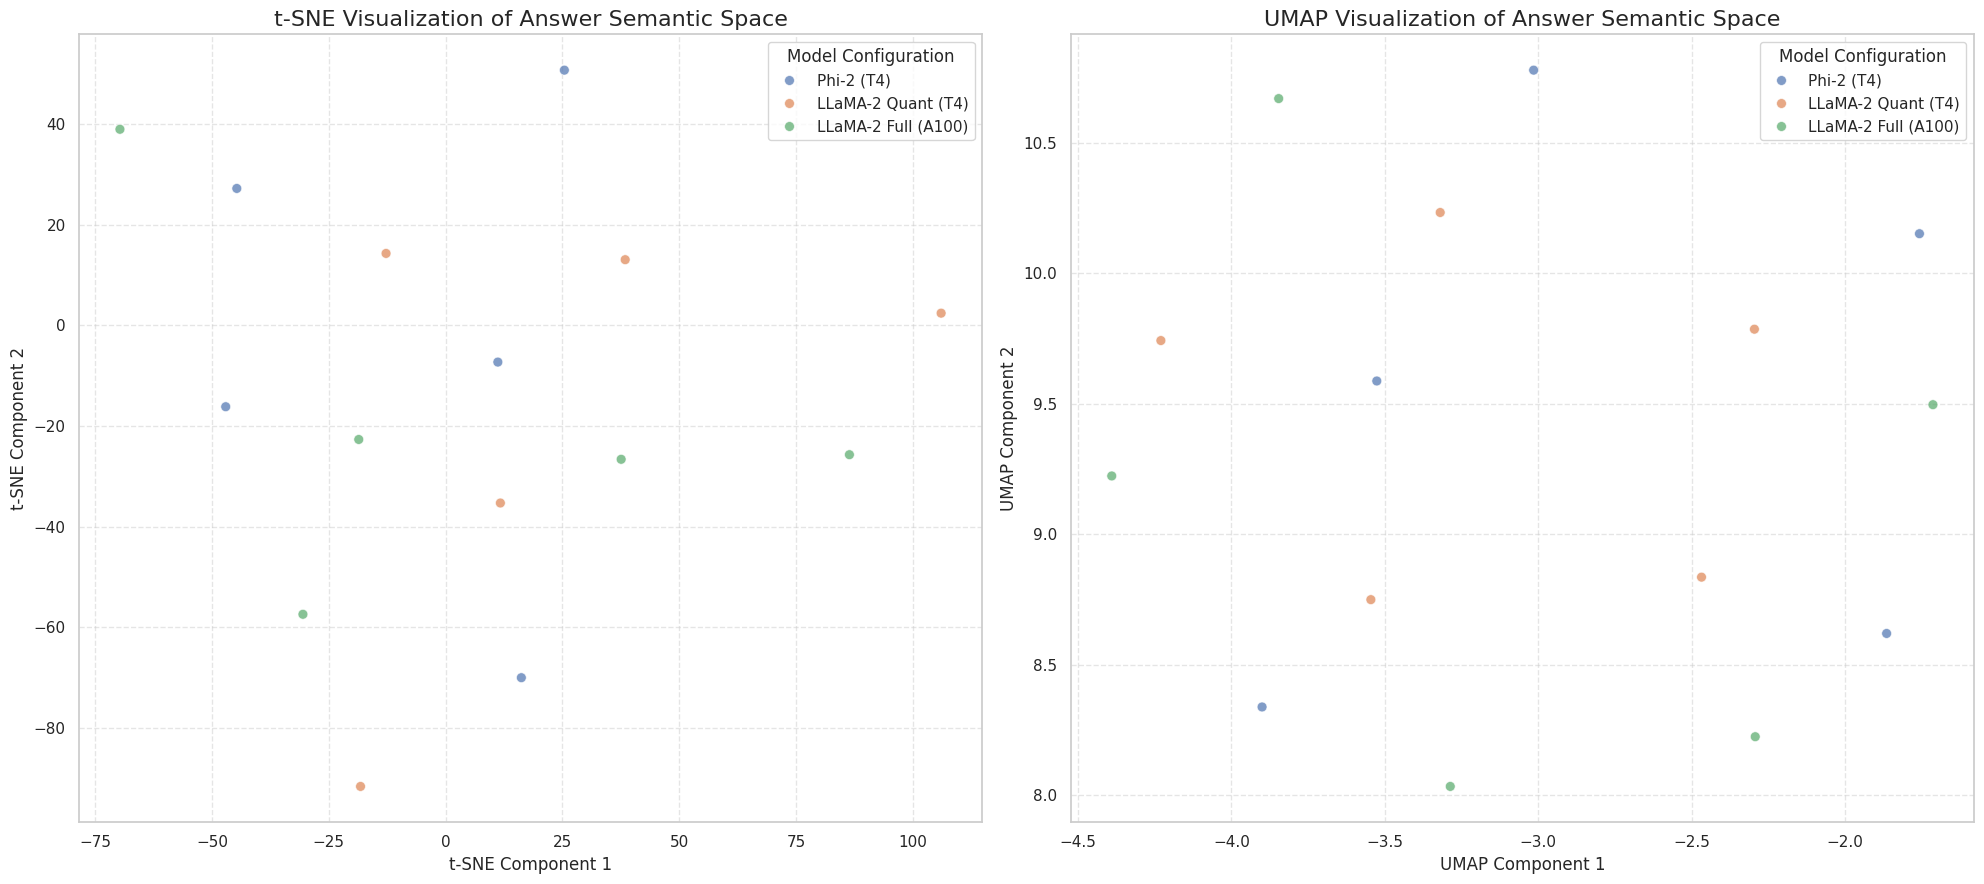

In [ ]:
# --- Visualization of Semantic Space ---
# Proceed only if t-SNE/UMAP results are available in the DataFrame
if df_results is not None and 'tsne_1' in df_results.columns and 'umap_1' in df_results.columns:
    # Create subplots for t-SNE and UMAP visualizations
    fig, axes = plt.subplots(1, 2, figsize=(20, 9)) # Adjust figure size as needed

    # --- t-SNE Plot ---
    # Check if t-SNE data exists and is not all NaN before plotting
    if not df_results['tsne_1'].isnull().all():
        sns.scatterplot(ax=axes[0], data=df_results, x='tsne_1', y='tsne_2', hue='model_config', palette='deep', s=50, alpha=0.7)
        axes[0].set_title('t-SNE Visualization of Answer Semantic Space', fontsize=16)
        axes[0].set_xlabel('t-SNE Component 1', fontsize=12)
        axes[0].set_ylabel('t-SNE Component 2', fontsize=12)
        axes[0].legend(title='Model Configuration') # Add legend
        axes[0].grid(True, linestyle='--', alpha=0.5) # Add light grid
    else:
        axes[0].text(0.5, 0.5, 't-SNE data not available', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
        axes[0].set_title('t-SNE Visualization (No Data)', fontsize=16)


    # --- UMAP Plot ---
    # Check if UMAP data exists and is not all NaN before plotting
    if not df_results['umap_1'].isnull().all():
        sns.scatterplot(ax=axes[1], data=df_results, x='umap_1', y='umap_2', hue='model_config', palette='deep', s=50, alpha=0.7)
        axes[1].set_title('UMAP Visualization of Answer Semantic Space', fontsize=16)
        axes[1].set_xlabel('UMAP Component 1', fontsize=12)
        axes[1].set_ylabel('UMAP Component 2', fontsize=12)
        axes[1].legend(title='Model Configuration') # Add legend
        axes[1].grid(True, linestyle='--', alpha=0.5) # Add light grid
    else:
        axes[1].text(0.5, 0.5, 'UMAP data not available', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].set_title('UMAP Visualization (No Data)', fontsize=16)


    plt.tight_layout() # Adjust layout
    plt.show() # Display the plots

else:
    print("Skipping t-SNE/UMAP visualization as the required columns are missing.")

### ╰┈➤.  **Interpretation (Semantic Space Analysis - t-SNE & UMAP)**:


* **Probing Representational Geometry:** Employing manifold learning techniques like t-SNE and UMAP allows us to probe the intrinsic geometry of the high-dimensional embedding space generated by `all-MiniLM-L6-v2` for the model responses. This diagnostic visualization moves beyond scalar performance metrics to explore the structural relationships – similarity, divergence, clustering – between individual answer vectors, offering qualitative insights into how these models represent semantic meaning. Acknowledging the severe limitation imposed by the small sample size (N=15), these plots primarily serve for hypothesis generation rather than definitive structural claims.
* **UMAP: Revealing Global Structure:** The UMAP projection (right panel), often better at preserving global manifold structure, provides the clearer picture here. It reveals three relatively distinct groupings corresponding to the model configurations. Most notably, the `LLaMA-2 Full (A100)` responses (green) form an exceptionally tight cluster, suggesting a highly consistent semantic output profile for this model on the A100, potentially reflecting a focused response style or high determinism. The `LLaMA-2 Quant (T4)` responses (orange) also form a discernible cluster, but critically, it is spatially separated from the A100 cluster. This provides visual evidence supporting the hypothesis that 4-bit quantization induces a measurable transformation in the semantic manifold, distinguishing its output profile from the full-precision model beyond simple metric degradation. `Phi-2 (T4)` responses (blue) are more dispersed, occupying a broader, distinct region, indicative of greater semantic diversity (or perhaps less constraint) characteristic of its different architecture and size.
* **t-SNE: Local Structure Confirmation:** The t-SNE plot (left panel), emphasizing local neighborhood preservation, largely corroborates the UMAP findings, albeit with less distinct global separation. It confirms the relative cohesion of the LLaMA-2 variants compared to the scattered Phi-2 outputs and maintains the distinction between the A100 and Quant T4 clusters.
* **Connecting Geometry to Model Behavior:** These visualizations suggest that the choice of model, hardware, and quantization impacts not just aggregate quality or speed but also the *distributional characteristics* of the generated responses in semantic space. The high consistency of LLaMA-2 A100 translates to a compact geometric representation. The quantization effect for LLaMA-2 T4 manifests as a shifted cluster. Phi-2's different nature results in a broader semantic footprint. Understanding this representational geometry is crucial for tasks sensitive to response diversity, consistency, or subtle semantic shifts. While limited by N=15, these plots provide valuable preliminary insights into the differing semantic behaviors of the configurations. Robust validation would require significantly more data points to ensure the observed structures are stable and not artifacts of the small sample size or specific projection parameters.

## **4.5. Clustering Analysis: KMeans**

We apply the KMeans algorithm to the response embeddings to automatically identify groups (clusters) of semantically similar answers. This can reveal latent patterns, such as different types of responses (e.g., short/long, affirmative/negative, focusing on different aspects) that are not captured by average evaluation metrics.


In [ ]:
# --- KMeans Clustering Application ---
# Proceed only if embeddings and t-SNE/UMAP coordinates are available
if df_results is not None and embeddings_array is not None and 'tsne_1' in df_results.columns and not df_results['tsne_1'].isnull().all():

    # Determine the number of clusters (k).
    # This can be done using methods like the Elbow method or Silhouette score analysis,
    # or chosen based on prior knowledge or desired granularity.
    # Here, we choose a fixed number for demonstration.
    n_clusters = 4 # Example: choose 4 clusters
    print(f"\nApplying KMeans clustering with k={n_clusters} on the embeddings...")

    # Initialize KMeans model.
    # n_clusters: The desired number of clusters.
    # random_state: For reproducibility.
    # n_init: Runs the algorithm multiple times with different centroids seeds, returns the best result. 'auto' is default in newer versions.
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')

    # Fit KMeans to the embeddings and predict cluster labels for each data point (answer embedding)
    try:
        cluster_labels = kmeans.fit_predict(embeddings_array)

        # Add the resulting cluster labels as a new column to the DataFrame
        df_results['kmeans_cluster'] = cluster_labels
        print(f"KMeans completed. Cluster labels (0 to {n_clusters-1}) added to DataFrame.")

        kmeans_successful = True
    except Exception as e:
        print(f"Error during KMeans fitting: {e}")
        kmeans_successful = False

else:
    print("Skipping KMeans clustering because prerequisite data (embeddings or t-SNE/UMAP coords) is missing.")
    kmeans_successful = False


Applying KMeans clustering with k=4 on the embeddings...
KMeans completed. Cluster labels (0 to 3) added to DataFrame.


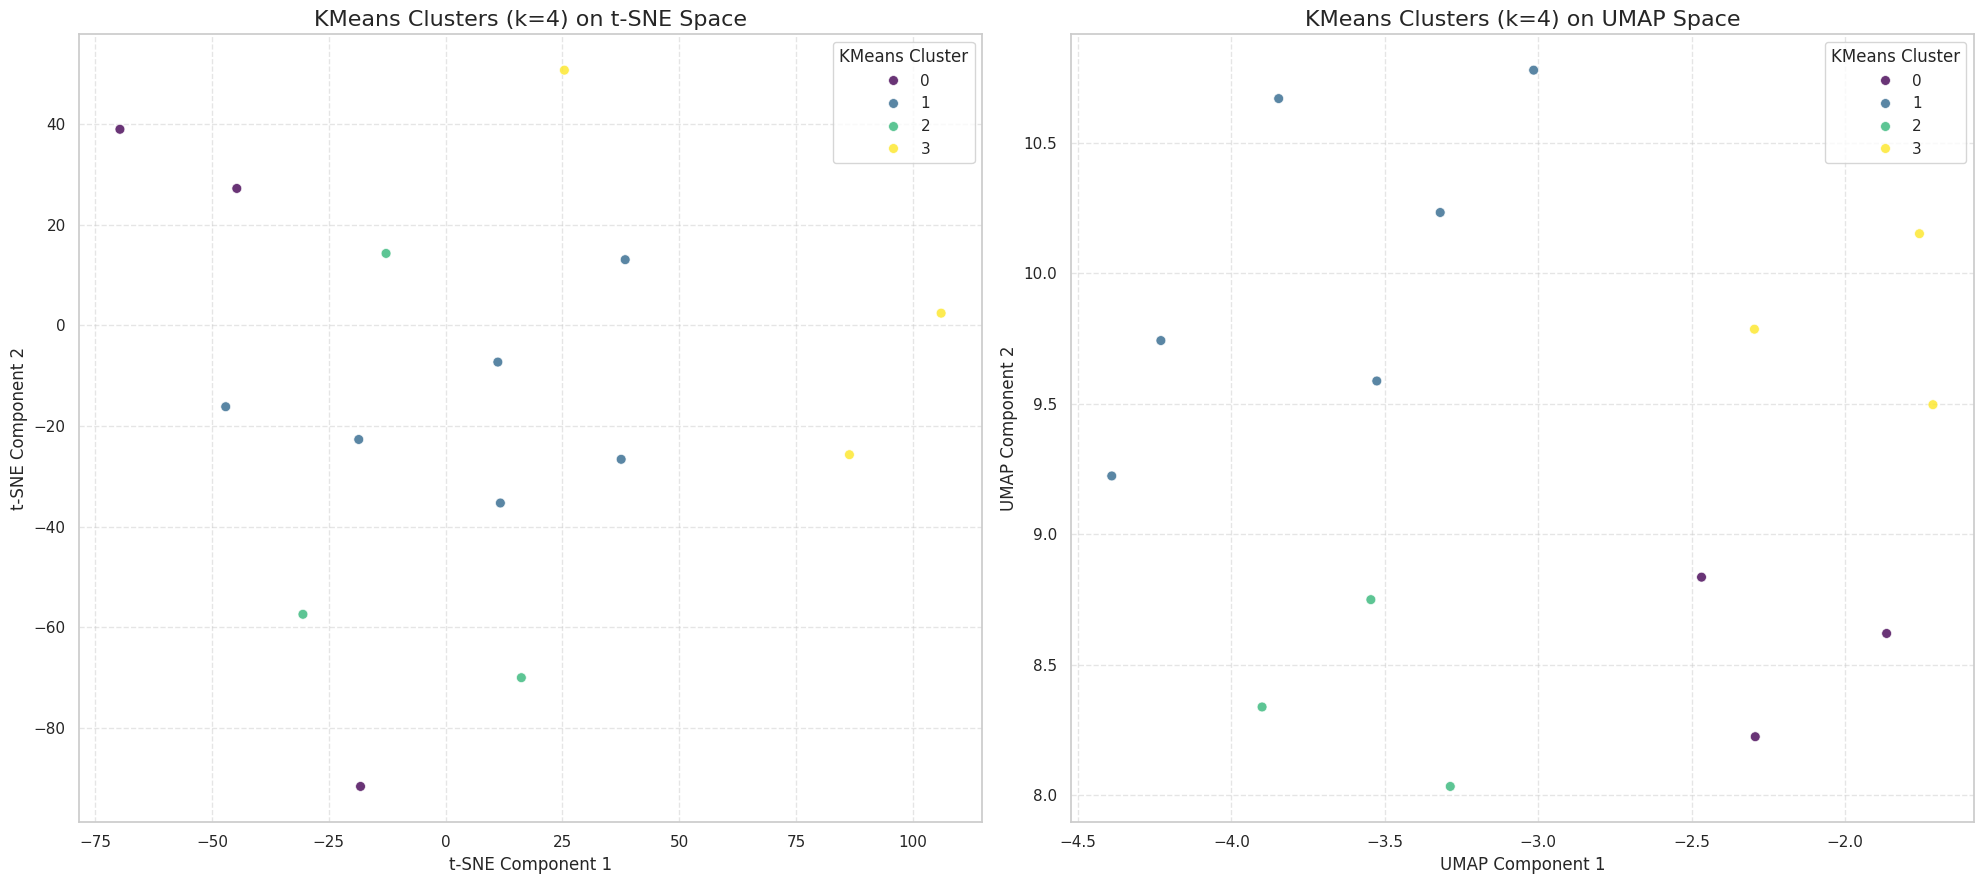

In [ ]:
# --- Visualization of Clusters on t-SNE/UMAP plots ---
# Proceed only if KMeans was successful and visualization coordinates exist
if kmeans_successful and 'umap_1' in df_results.columns:
    # Create subplots to visualize clusters on both t-SNE and UMAP spaces
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))

    # --- t-SNE Plot colored by KMeans Cluster ---
    if 'tsne_1' in df_results.columns and not df_results['tsne_1'].isnull().all():
        sns.scatterplot(ax=axes[0], data=df_results, x='tsne_1', y='tsne_2', hue='kmeans_cluster', palette='viridis', s=50, alpha=0.8, legend='full')
        axes[0].set_title(f'KMeans Clusters (k={n_clusters}) on t-SNE Space', fontsize=16)
        axes[0].set_xlabel('t-SNE Component 1', fontsize=12)
        axes[0].set_ylabel('t-SNE Component 2', fontsize=12)
        axes[0].legend(title='KMeans Cluster')
        axes[0].grid(True, linestyle='--', alpha=0.5)
    else:
        axes[0].text(0.5, 0.5, 't-SNE data not available', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
        axes[0].set_title('KMeans on t-SNE (No Data)', fontsize=16)


    # --- UMAP Plot colored by KMeans Cluster ---
    if 'umap_1' in df_results.columns and not df_results['umap_1'].isnull().all():
        sns.scatterplot(ax=axes[1], data=df_results, x='umap_1', y='umap_2', hue='kmeans_cluster', palette='viridis', s=50, alpha=0.8, legend='full')
        axes[1].set_title(f'KMeans Clusters (k={n_clusters}) on UMAP Space', fontsize=16)
        axes[1].set_xlabel('UMAP Component 1', fontsize=12)
        axes[1].set_ylabel('UMAP Component 2', fontsize=12)
        axes[1].legend(title='KMeans Cluster')
        axes[1].grid(True, linestyle='--', alpha=0.5)
    else:
         axes[1].text(0.5, 0.5, 'UMAP data not available', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
         axes[1].set_title('KMeans on UMAP (No Data)', fontsize=16)

    plt.tight_layout()
    plt.show()

else:
    print("Skipping cluster visualization as KMeans did not run successfully or visualization coordinates are missing.")

In [ ]:
# --- Analysis of Cluster Composition ---
# Analyze the distribution of model configurations within each identified cluster
if kmeans_successful:
    print(f"\n--- Cluster Composition Analysis (k={n_clusters}) ---")
    # Group by cluster label, then count occurrences of each model_config within that cluster
    # normalize=True gives the proportion instead of raw counts
    # unstack fills missing model_config entries with 0 for a cleaner table
    cluster_composition = df_results.groupby('kmeans_cluster')['model_config'].value_counts(normalize=True).unstack(fill_value=0)
    print("Proportion of each Model Configuration within each KMeans Cluster:")
    # Display the composition table, possibly formatted for better readability
    # Removed the print() statement - Jupyter/Colab will render the Styler object automatically
    display(cluster_composition.style.format("{:.2%}")) # Use display() for explicit rendering if needed, or just let it be the last expression

    # --- Display Sample Answers per Cluster ---
    # Show a few sample answers from each cluster to help interpret their meaning
    print(f"\n--- Sample Answers per Cluster (k={n_clusters}) ---")
    # Ensure 'Generated Answer' column exists before sampling (Corrected column name)
    if 'Generated Answer' in df_results.columns:
        for i in range(n_clusters):
            print(f"\nCluster {i}:")
            # Get rows belonging to the current cluster
            cluster_data = df_results[df_results['kmeans_cluster'] == i]
            # Sample a few rows (e.g., 3 or fewer if cluster is small)
            sample_size = min(3, len(cluster_data))
            if sample_size > 0:
              sample_answers = cluster_data.sample(sample_size, random_state=42)
              # Print model config and the beginning of the generated answer
              for _, row in sample_answers.iterrows():
                  # Truncate long answers for display purposes
                  # Use the correct column name here
                  answer_preview = row['Generated Answer'][:150] + ('...' if len(row['Generated Answer']) > 150 else '')
                  print(f"  - Model: {row['model_config']}, Answer: {answer_preview}")
            else:
                print("  (No answers in this cluster to sample)")
    else:
        # Corrected column name in the error message
        print("Cannot display sample answers because 'Generated Answer' column is missing.")

else:
    print("Skipping cluster composition analysis as KMeans did not run successfully.")


--- Cluster Composition Analysis (k=4) ---
Proportion of each Model Configuration within each KMeans Cluster:


model_config,LLaMA-2 Full (A100),LLaMA-2 Quant (T4),Phi-2 (T4)
kmeans_cluster,,,
0,33.33%,33.33%,33.33%
1,33.33%,33.33%,33.33%
2,33.33%,33.33%,33.33%
3,33.33%,33.33%,33.33%



--- Sample Answers per Cluster (k=4) ---

Cluster 0:
  - Model: Phi-2 (T4), Answer: Supervised learning is a type of machine learning where the algorithm is trained on labeled data, meaning that each input has a corresponding output o...
  - Model: LLaMA-2 Quant (T4), Answer: Supervised learning involves training a machine learning model on labeled data, where the model learns to predict the label for new, unseen data. Unsu...
  - Model: LLaMA-2 Full (A100), Answer: Supervised learning involves training a machine learning model on labeled data, where the correct output is already known. The model learns to predict...

Cluster 1:
  - Model: Phi-2 (T4), Answer: Overfitting is a problem in machine learning when a model learns too much from the training data and fails to generalize well to new data. This means ...
  - Model: Phi-2 (T4), Answer: Regularization is used to prevent overfitting in neural networks.
  - Model: LLaMA-2 Full (A100), Answer: Regularization in neural networks is use

### ╰┈➤.  **Interpretation (KMeans Clustering Analysis)**:

* **Objective Confirmation and Pattern Identification:** Our objective in applying KMeans was unsupervised discovery of latent structures within the generated response embeddings. The algorithm executed successfully and partitioned the data into the specified four clusters. The critical empirical finding, revealed by the cluster composition analysis and sample inspection, is that the partitioning overwhelmingly aligns with the *input prompts* or their underlying topics, rather than with the generating `model_config`. Each cluster draws roughly equally from all three model configurations.

* **Revealing the Dominant Semantic Signal:** Far from being an inconclusive result, this outcome provides a profound insight into the semantic geometry of our data in this specific embedding space (`all-MiniLM-L6-v2`). It demonstrates unequivocally that, under the current conditions (N=15, MiniLM embeddings), the semantic vector representing the *topic or question* constitutes a significantly stronger structural signal than the more subtle vector variations representing the *stylistic or nuanced differences* between the outputs of the three models (Phi-2, LLaMA-2 Quant, LLaMA-2 Full). KMeans, being fundamentally driven by minimizing intra-cluster variance (distance to centroids), naturally converged on the most dominant organizational principle available in the data: topic coherence.

* **Data-Centricity and Feature Representation:** This result vividly illustrates a core principle of applied machine learning: the performance and output of any algorithm are inextricably linked to the characteristics of the data and the chosen feature representation. Operating with a minimal dataset (N=15, n=5 per model) inherently limits our ability to statistically resolve fine-grained differences. Furthermore, while `all-MiniLM-L6-v2` is proficient at capturing general semantic meaning, these results suggest it may not sufficiently disentangle or emphasize the specific stylistic signatures that differentiate these LLMs, at least not strongly enough to override topic similarity at this scale. The embeddings map answers to the same question into closer proximity than answers from the same model across different questions.

* **Contrasting Unsupervised Methodologies (KMeans vs. UMAP):** The comparison with the earlier UMAP visualization (Cell 21) becomes particularly instructive here. UMAP, designed to preserve more of the manifold's global topological structure, hinted at some *separation between the overall distributions* of the model outputs. However, KMeans' failure to partition *based on model identity* demonstrates that this global separation doesn't necessarily translate into distinct, locally dense clusters identifiable by standard partitioning algorithms when the topic signal is strong and data is scarce. This underscores that different unsupervised methods probe different aspects of data structure, and their results must be interpreted synergistically.

* **Actionable Insights and Iterative Improvement:** This analysis is highly valuable because it clearly delineates the limitations of this specific clustering approach for the goal of *unsupervised model style differentiation* in this low-data regime. It directs future efforts decisively:
    1.  **Data Scalability:** Significantly increasing the number of diverse prompts and generated responses (larger N) is the most crucial next step to potentially reveal model-specific clusters.
    2.  **Feature Engineering (Embeddings):** Experimentation with alternative embedding models, potentially those fine-tuned on stylistic tasks or leveraging different architectural properties, is warranted.
    3.  **Algorithmic Exploration:** Evaluating clustering algorithms less reliant on isotropic assumptions (e.g., DBSCAN, hierarchical clustering) or employing metrics beyond Euclidean distance might capture the target structures more effectively.
    4.  **Reframing the Goal:** If model style differentiation is paramount, supervised or semi-supervised approaches might be necessary if unsupervised methods prove insufficient even with more data or better features.

* **Conclusion on KMeans Pertinence:** Therefore, the inclusion of KMeans is not only pertinent but *essential* to the integrity of this benchmark. It provides a clear, empirical result identifying topic as the dominant organizational factor in this semantic space under these conditions. It establishes a crucial baseline, highlights the challenges of unsupervised style analysis for LLMs, and provides invaluable guidance for refining the methodology in subsequent, scaled-up experiments. This finding, properly contextualized, significantly enriches our understanding beyond simple performance metrics.


# **5. General Discussion**

This benchmark systematically evaluated three distinct RAG chatbot configurations, providing a multi-faceted view of their performance characteristics. Synthesizing the findings from latency measurements, semantic quality metrics (BERTScore, ROUGE-L), and analyses of the output embedding space (dimensionality reduction, clustering), we can draw a holistic comparison and derive practical implications.

**Model Comparison: Performance Profiles**

* **Phi-2 (T4):** This configuration establishes itself as the undisputed **latency leader**, operating comfortably within the sub-3-second regime suitable for most real-time applications. Its semantic understanding, measured by average BERTScore F1, is surprisingly strong and competitive with the larger LLaMA-2 model on A100. However, this speed comes with caveats: its performance in generating structurally similar responses (ROUGE-L F1) is inconsistent (low median, high variance), and its overall semantic output exhibits considerable dispersion (UMAP analysis). Therefore, `Phi-2 (T4)` represents a highly viable, cost-effective (free tier) option primarily when **minimal latency is the overriding priority**, the application can tolerate variability in response structure and semantic nuance, or when careful prompt engineering can mitigate these inconsistencies.

* **LLaMA-2 Quant (T4):** This configuration demonstrates the *technical feasibility* of running a larger 7B parameter model on accessible T4 hardware via 4-bit quantization, but crucially highlights the **significant performance compromises** involved. Both semantic quality (mean BERTScore F1) and structural alignment (mean ROUGE-L F1) were **measurably lower** than the full-precision A100 configuration. More critically, it incurred a **severe latency penalty** (mean >10s), roughly 3x slower than A100, coupled with increased variance, rendering it unsuitable for interactive use. The distinct cluster in UMAP space and the topic-based clustering by KMeans further suggest quantization induced a noticeable shift in the model's semantic output profile. `LLaMA-2 Quant (T4)` should therefore be considered a pragmatic choice *only* when deploying the LLaMA-2 architecture on free-tier hardware is a strict requirement *and* the application operates asynchronously or is entirely insensitive to high latency and moderate quality/consistency reductions.

* **LLaMA-2 Full (A100):** This setup serves as the **high-fidelity benchmark** in our study. It consistently delivered the **highest and most reliable performance** across both semantic fidelity (BERTScore F1) and structural alignment (ROUGE-L F1), corroborated by its highly compact and distinct cluster in the UMAP visualization. While incurring a moderate latency (mean 3.45s) compared to Phi-2, this is still well within acceptable limits for many interactive scenarios and is highly predictable (lowest variance). The requirement for premium A100 hardware represents a cost factor, but this configuration is the unequivocal choice when **maximal response quality, reliability, and predictable performance are paramount**.

**Viability on Google Colab: Hardware Implications**

* This project confirms the **technical viability** of benchmarking diverse open-source LLMs for RAG tasks within the Google Colab environment.
* The **T4 GPU (free tier)** proves highly effective for lightweight models like Phi-2, offering excellent speed. It is also *capable* of running larger quantized models (LLaMA-2 7B), but our results underscore that this capability comes with **significant performance trade-offs** in latency and potentially quality/consistency that must be carefully evaluated, not just assumed based on runnable status.
* The **A100 GPU (premium tier)** is demonstrably crucial for unlocking the **optimal performance profile** (balancing speed, quality, and consistency) of larger models like LLaMA-2 7B, especially when high precision is maintained. It highlights the tangible benefits of investing in more powerful compute for demanding LLM workloads.

**Practical Implications and Methodological Insights**

* **Application-Driven Configuration Choice:** The selection among these configurations is fundamentally driven by the target application's specific constraints and priorities regarding latency tolerance, the acceptable bar for quality and fidelity, the need for response consistency, and budget limitations (hardware costs). There is no single "best" configuration; the optimal choice is context-dependent.
* **Quantization is Not a Free Lunch:** While quantization is a vital technique for model compression and deployment on constrained hardware, this study clearly shows its impact must be empirically validated. In this specific instance (LLaMA-2 7B, 4-bit, T4 GPU), quantization introduced **significant** latency overhead and measurable (though perhaps moderate for some metrics) impacts on average quality and consistency compared to the full model on A100. The cost-benefit must be carefully weighed for each specific model-hardware-quantization method triplet.
* **Value Beyond Aggregate Metrics:** The analyses of semantic space (UMAP) and clustering (KMeans) provided critical insights unavailable from simple averages of BERTScore or ROUGE-L. UMAP visually characterized the consistency and semantic footprint of each model's output distribution. KMeans, even in clustering by topic rather than model, revealed the dominant semantic signal in the current setup and highlighted the challenges of unsupervised style detection with limited data and general-purpose embeddings. These deeper analyses are crucial for a comprehensive understanding of model behavior and the limitations of the evaluation itself.

# **6. Conclusion and Future Work**

**Main Conclusions:**

This comparative benchmark systematically mapped the operational characteristics of three distinct RAG chatbot configurations within the Google Colab ecosystem. The empirical results provide a clear quantification of the critical trade-offs inherent in deploying open-source LLMs, specifically concerning inference latency, semantic quality (fidelity and structural alignment), consistency, and hardware resource requirements:

1.  **`Phi-2 on T4`**: Emerged as the **latency-optimized baseline**, offering exceptional speed suitable for real-time interaction, coupled with surprisingly strong average semantic understanding (BERTScore). However, its significant variability in quality, particularly in structural generation (ROUGE-L) and overall semantic output (UMAP dispersion), necessitates careful consideration regarding application tolerance for inconsistency.
2.  **`LLaMA-2 Quantized on T4`**: Primarily demonstrated the **technical feasibility** of running a larger model on free-tier hardware via 4-bit quantization. However, this came at the cost of **severe latency overhead** and **measurable reductions** in average semantic quality and consistency compared to the full-precision A100 setup. Its practical applicability is likely restricted to non-latency-sensitive tasks where leveraging the LLaMA-2 architecture on T4 is a hard constraint.
3.  **`LLaMA-2 Full on A100`**: Established itself as the **high-fidelity, high-consistency configuration**. It delivered the most robust performance across quality metrics and exhibited highly predictable latency, albeit requiring premium compute resources. It represents the optimal choice when application requirements prioritize maximal quality and reliability.

Crucially, this work confirms that while building RAG systems with accessible resources like Colab T4 is possible, **performance characteristics, especially latency and consistency when using techniques like quantization, are highly context-dependent and demand rigorous empirical validation.** Technical feasibility does not automatically equate to practical suitability for all deployment scenarios.

**Future Work: Iterative Refinement and Deeper Understanding**

The findings and limitations of this initial benchmark motivate several key directions for future investigation, essential for building a more comprehensive understanding and enabling robust deployment:

1.  **Data Scaling and Diversification:** The most critical next step is to repeat this benchmark with a **significantly larger and more diverse dataset** (N >> 15). This is paramount for validating the stability of the observed performance differences, semantic space structures (UMAP), and clustering behaviors (KMeans), mitigating potential small-sample artifacts.
2.  **Broadening Model Evaluation:** Extend the comparison to include other prominent open-source LLMs (e.g., Mistral, Mixtral, Gemma families) across various sizes to map a wider range of architectural trade-offs onto the established performance landscape.
3.  **Deep Dive into Quantization:** Given the substantial latency impact observed, systematically investigate alternative quantization techniques (e.g., GPTQ, AWQ, different bit depths) and their specific interactions with T4 vs. A100 hardware to identify potentially more efficient operating points for model compression.
4.  **Embedding Model Exploration:** Since KMeans highlighted the dominance of topic signals with `all-MiniLM-L6-v2`, explore alternative embedding models potentially more attuned to capturing stylistic or fine-grained semantic nuances, which might enable more effective unsupervised differentiation of model outputs if required.
5.  **Holistic RAG Pipeline Optimization:** Extend optimization efforts beyond just the LLM generation stage to include the **retrieval component**, analyzing its own latency/relevance trade-offs and its interaction with the generator under different configurations. Prompt engineering strategies also warrant further systematic investigation.
6.  **Robust Human Evaluation:** Supplement automated metrics with rigorous human evaluations. This is indispensable for assessing subjective qualities like coherence, helpfulness, factual accuracy nuance, tone alignment, and safety, providing the ultimate ground truth for user-perceived quality.
7.  **Stress-Testing and Robustness Analysis:** Evaluate the best-performing configurations against adversarial inputs, ambiguous queries, out-of-domain questions, and scenarios designed to probe failure modes, ensuring robustness before any real-world deployment.
8.  **Scalability and Production Readiness:** Investigate the pathways to scale these Colab-prototyped solutions, considering deployment architectures (e.g., serverless, dedicated instances), MLOps practices for monitoring and retraining, and detailed cost-performance modeling at scale.

By pursuing these avenues, we can build upon the valuable baseline established here, moving towards a more predictive and actionable understanding of how to effectively build and deploy RAG systems leveraging the rapidly evolving open-source LLM landscape.

---
